# Test technique PRO BTP Data Scientist - Open Data SNCF Dataset

# Stéphane PETIOT

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Récupération du dataset CSV

In [2]:
df_sncf = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv', sep = ';')
df_sncf

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2020-01-03,800,852,432,LE PERRAY,62804.0,TST,Moins de 5
1,2020-01-03,800,852,515,MAREIL-SUR-MAULDRE,64572.0,NAVIGO,18
2,2020-01-03,800,852,526,MAULE,64674.0,AMETHYSTE,Moins de 5
3,2020-01-03,800,852,538,MEUDON,70515.0,TST,Moins de 5
4,2020-01-03,800,852,561,MONTPARNASSE,71139.0,IMAGINE R,1600
...,...,...,...,...,...,...,...,...
835136,2020-05-15,100,110,778,SAINT-PHILIPPE-DU-ROULE,71334.0,AMETHYSTE,19
835137,2020-05-15,100,110,778,SAINT-PHILIPPE-DU-ROULE,71334.0,NON DEFINI,18
835138,2020-05-15,100,110,780,SAINT-SEBASTIEN FROISSART,71777.0,AUTRE TITRE,37
835139,2020-05-15,100,110,781,SAINT-SULPICE,71202.0,AUTRE TITRE,41


## Exploration des données

In [3]:
# Description des différentes données d'entrées
pd.set_option('max_colwidth', None)
pd.DataFrame(
    data = {
        'VARIABLES' : ['JOUR', 'COD_STIF_TRNS', 'COD_STIF_RES', 'COD_STIF_ARRET', 'LIBELLE_ARRET', 'ID_REFA_LDA', 'CATEGORIE_TITRE', 'NB_VALD'],
        'FORMAT' : ['Date', 'Numérique', 'Numérique', 'Numérique', 'Caractère', 'Caractère', 'Caractère', 'Numérique'],
        'DEFINITION' : ['Jour d’exploitation (de 04:00 à 03:59 le lendemain)', 'Code Stif du transporteur', 'Code Stif du réseau', 'Code Stif de l’arrêt/station', 'Libellé de l’arrêt/station', 'Identifiant arrêt référentiel STIF', 'Titre de transport', 'Nombre de validations (en entrée sur le réseau)']
    }
).style.hide_index()

VARIABLES,FORMAT,DEFINITION
JOUR,Date,Jour d’exploitation (de 04:00 à 03:59 le lendemain)
COD_STIF_TRNS,Numérique,Code Stif du transporteur
COD_STIF_RES,Numérique,Code Stif du réseau
COD_STIF_ARRET,Numérique,Code Stif de l’arrêt/station
LIBELLE_ARRET,Caractère,Libellé de l’arrêt/station
ID_REFA_LDA,Caractère,Identifiant arrêt référentiel STIF
CATEGORIE_TITRE,Caractère,Titre de transport
NB_VALD,Numérique,Nombre de validations (en entrée sur le réseau)


In [4]:
# Assurons-nous que les données soient au bon format
df_sncf.dtypes

JOUR                object
CODE_STIF_TRNS       int64
CODE_STIF_RES       object
CODE_STIF_ARRET     object
LIBELLE_ARRET       object
ID_REFA_LDA        float64
CATEGORIE_TITRE     object
NB_VALD             object
dtype: object

## Pré-traitement et nettoyage des données

In [5]:
# Date : on utilise le format datetime de pandas
df_sncf['JOUR'] = pd.to_datetime(df_sncf['JOUR'])
#df_sncf = df_sncf.sort_values('JOUR')

# La connaissance de la date précise n'est pas forcément pertinente dans le cadre d'une prédiction de volume de transport
# Ce qui peut en revanche être pertinent, c'est de connaître le jour de la semaine ainsi que le mois de l'année, car l'affluence
# peut varier significativement en fonction de ces deux données
df_sncf['DayOfWeek'] = df_sncf['JOUR'].dt.dayofweek
df_sncf['Month'] = df_sncf['JOUR'].dt.month


In [6]:
# Dates :
df_sncf['DayOfWeek'] = pd.to_numeric(df_sncf['DayOfWeek'], downcast = 'unsigned')
df_sncf['Month'] = pd.to_numeric(df_sncf['Month'], downcast = 'unsigned')

# Codes STIF :
df_sncf['CODE_STIF_TRNS'] = pd.to_numeric(df_sncf['CODE_STIF_TRNS'], downcast = 'unsigned')
# Il existe quelques rares anomalies (Valeurs 'ND', Non Desservis ? Interruptions sur la ligne ?)
# On va donc utiliser une expression régulière (RegEx)
df_sncf['CODE_STIF_RES'] = pd.to_numeric(df_sncf['CODE_STIF_RES'].str.extract('(\d+)')[0].astype(float), downcast = 'unsigned')
df_sncf['CODE_STIF_ARRET'] = pd.to_numeric(df_sncf['CODE_STIF_ARRET'].str.extract('(\d+)')[0].astype(float), downcast = 'unsigned')

# Les Identifiants arrêt sont également des entiers naturels (initialement au format 'float')
df_sncf['ID_REFA_LDA'] = pd.to_numeric(df_sncf['ID_REFA_LDA'], downcast = 'unsigned')

In [7]:
# Vérification des formats
df_sncf.dtypes

JOUR               datetime64[ns]
CODE_STIF_TRNS             uint16
CODE_STIF_RES             float64
CODE_STIF_ARRET           float64
LIBELLE_ARRET              object
ID_REFA_LDA               float64
CATEGORIE_TITRE            object
NB_VALD                    object
DayOfWeek                   uint8
Month                       uint8
dtype: object

In [8]:
# La présence de valeurs non numériques dans les données empêche de caster les données de type float vers le type unsigned int
# Evaluons les données manquantes
pd.DataFrame(
    [df_sncf.isnull().sum(), (df_sncf.isnull().sum()/df_sncf.shape[0]) * 100],
    index = ['Total Missing Values', '% Missing Values']
)

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,DayOfWeek,Month
Total Missing Values,0.0,0.0,772.000000,772.000000,0.0,43848.000000,0.0,0.0,0.0,0.0
% Missing Values,0.0,0.0,0.092439,0.092439,0.0,5.250371,0.0,0.0,0.0,0.0


In [9]:
df_sncf.dropna(subset = ['CODE_STIF_RES', 'CODE_STIF_ARRET'], inplace = True)

In [10]:
# Il y a toutefois quelques exceptions, certains ID_REFA_LDA sont associés à plusieurs CODE_STIF_ARRET
redundancy_df = df_sncf[['CODE_STIF_ARRET', 'ID_REFA_LDA']].groupby(['ID_REFA_LDA']).nunique()
#print(redundancy_df.loc[~((redundancy_df['CODE_STIF_ARRET'] == 1) & (redundancy_df['ID_REFA_LDA'] == 1))])

# Il y a également quelques CODE_STIF_ARRET qui n'ont pas de ID_REFA_LDA associés
redundancy_df = df_sncf[['ID_REFA_LDA', 'CODE_STIF_ARRET']].groupby(['CODE_STIF_ARRET']).nunique()
#print(redundancy_df.loc[~((redundancy_df['CODE_STIF_ARRET'] == 1) & (redundancy_df['ID_REFA_LDA'] == 1))])

# Ces exemples sont assez minoritaires dans l'ensemble des valeurs possibles, on va donc considérer que les CODE_STIF_ARRET et
# ID_REFA_LDA sont redondantes
df_sncf = df_sncf.drop('ID_REFA_LDA', axis = 1)

In [11]:
df_sncf['CODE_STIF_RES'] = pd.to_numeric(df_sncf['CODE_STIF_RES'], downcast = 'unsigned')
df_sncf['CODE_STIF_ARRET'] = pd.to_numeric(df_sncf['CODE_STIF_ARRET'], downcast = 'unsigned')
df_sncf.dtypes

JOUR               datetime64[ns]
CODE_STIF_TRNS             uint16
CODE_STIF_RES              uint16
CODE_STIF_ARRET            uint16
LIBELLE_ARRET              object
CATEGORIE_TITRE            object
NB_VALD                    object
DayOfWeek                   uint8
Month                       uint8
dtype: object

In [12]:
# Enfin, il s'agit de traiter la donnée NB_VALD, composée entièrement d'entiers naturels, à l'exception des échantillons pour
# lesquels la valeur est inférieure (stricte) à 5, auquel cas il est inscrit 'Moins de 5'. Il ne s'agit pas de valeurs
# minoritaires
print(df_sncf.loc[df_sncf['NB_VALD'] == 'Moins de 5'].shape[0])

161244


In [13]:
# Arbitrairement, on va donc affecter à ces données la valeur 3, pour indiquer qu'il s'agit d'un pass avec moins de 5 validations
df_sncf['NB_VALD'] = df_sncf['NB_VALD'].apply(lambda x : 3 if x == 'Moins de 5' else x)

In [14]:
df_sncf['NB_VALD'] = pd.to_numeric(df_sncf['NB_VALD'], downcast = 'unsigned')
df_sncf.dtypes

JOUR               datetime64[ns]
CODE_STIF_TRNS             uint16
CODE_STIF_RES              uint16
CODE_STIF_ARRET            uint16
LIBELLE_ARRET              object
CATEGORIE_TITRE            object
NB_VALD                    uint32
DayOfWeek                   uint8
Month                       uint8
dtype: object

In [15]:
df_sncf.corr().abs().style.applymap(lambda val : 'color : red' if val > 0.9 else 'color : black')

,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,NB_VALD,DayOfWeek,Month
CODE_STIF_TRNS,1.000000,0.998813,0.167322,0.068002,0.024506,0.013018
CODE_STIF_RES,0.998813,1.000000,0.165064,0.068645,0.024576,0.013338
CODE_STIF_ARRET,0.167322,0.165064,1.000000,0.033046,0.001413,0.000826
NB_VALD,0.068002,0.068645,0.033046,1.000000,0.044314,0.083494
DayOfWeek,0.024506,0.024576,0.001413,0.044314,1.000000,0.014686
Month,0.013018,0.013338,0.000826,0.083494,0.014686,1.000000


In [16]:
# Les features CODE_STIF_TRNS et CODE_STIF_RES sont corrélées à plus de 99%, elles sont donc porteuses de la même information
# On va donc conserver une seule de ces deux données d'entrée.
df_sncf = df_sncf.drop('CODE_STIF_RES', axis = 1)

In [17]:
# La phase de pré-traitement et de nettoyage des données est à présent terminée, et nous pouvons commencer notre analyse à
# partir du dataset suivant
df_sncf.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_ARRET,LIBELLE_ARRET,CATEGORIE_TITRE,NB_VALD,DayOfWeek,Month
0,2020-01-03,800,432,LE PERRAY,TST,3,4,1
1,2020-01-03,800,515,MAREIL-SUR-MAULDRE,NAVIGO,18,4,1
2,2020-01-03,800,526,MAULE,AMETHYSTE,3,4,1
3,2020-01-03,800,538,MEUDON,TST,3,4,1
4,2020-01-03,800,561,MONTPARNASSE,IMAGINE R,1600,4,1


## Question : Quelles sont les 20 premières stations en terme de validations ?

In [18]:
df_sncf_nbVal = df_sncf[['LIBELLE_ARRET', 'NB_VALD']].groupby('LIBELLE_ARRET').sum().sort_values('NB_VALD', ascending = False)
df_sncf_nbVal.head(20)

,NB_VALD
LIBELLE_ARRET,
SAINT-LAZARE,17775377
GARE DU NORD,7538501
MONTPARNASSE,6726059
GARE DE L'EST,5842491
LA DEFENSE-GRANDE ARCHE,5413369
GARE DE LYON,4077208
BIBLIOTHEQUE FRANCOIS MITTERRAND,3250739
LES HALLES,3033970
CHATELET-LES HALLES,2866968


## Question : Proposez une illustration graphique de ce classement

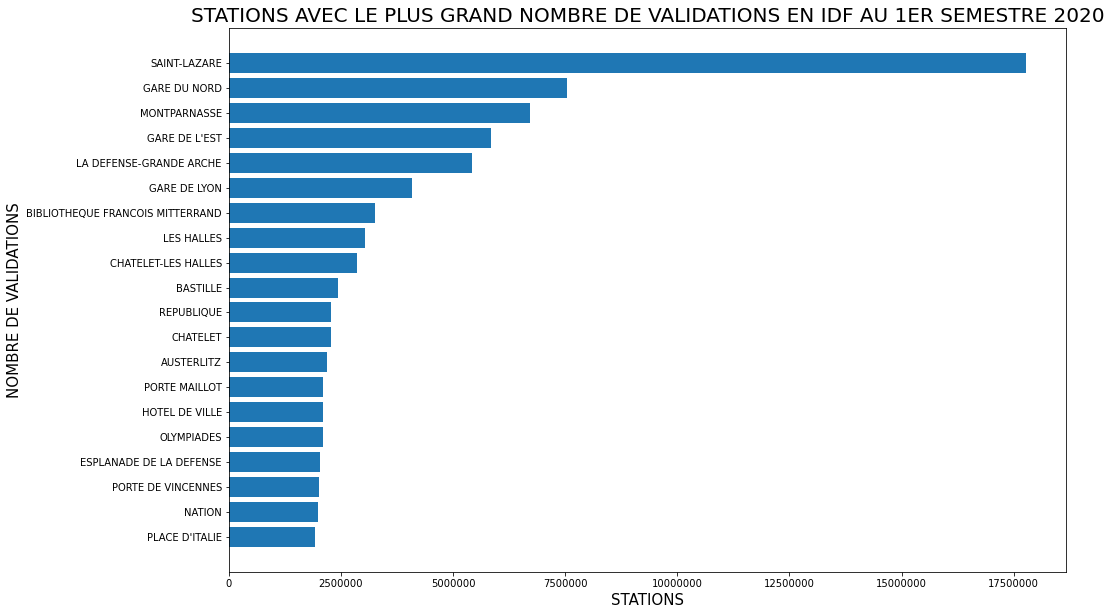

In [19]:
plt.figure(figsize = (15, 10))
plt.barh(df_sncf_nbVal.head(20)['NB_VALD'].sort_values().index, df_sncf_nbVal.head(20)['NB_VALD'].sort_values())
plt.ticklabel_format(style = 'plain', axis = 'x')
plt.title('STATIONS AVEC LE PLUS GRAND NOMBRE DE VALIDATIONS EN IDF AU 1ER SEMESTRE 2020', fontsize = 20)
plt.xlabel('STATIONS', fontsize = 15)
plt.ylabel('NOMBRE DE VALIDATIONS', fontsize = 15)
plt.show()

## Question : Proposez une classification des arrêts en vous basant sur le nombre de validations par catégorie de titre ?

In [20]:
# Décommenter pour affichage complet des DataFrames
#pd.set_option('display.max_rows', None)
# Décommenter pour réinitialiser l'option d'affichage
#pd.reset_option('display.max_rows')

# Une classification des arrêts basée sur le nombre de validation par catégorie de titre est obtenue grâce à la méthode
# 'groupby' de Pandas
df_classif = df_sncf[['LIBELLE_ARRET', 'NB_VALD', 'CATEGORIE_TITRE']].groupby(['LIBELLE_ARRET', 'CATEGORIE_TITRE']).sum()
print(df_classif.groupby('LIBELLE_ARRET', as_index = False).apply(lambda x : x.sort_values('NB_VALD', ascending = False)))

# Il peut également être intéressant de connaître la classification des arrêts basée sur la moyenne du nombre de validations
# par catégorie de titre
df_classif = df_sncf[['LIBELLE_ARRET', 'NB_VALD', 'CATEGORIE_TITRE']].groupby(['LIBELLE_ARRET', 'CATEGORIE_TITRE']).mean()
print(df_classif.groupby('LIBELLE_ARRET', as_index = False).apply(lambda x : x.sort_values('NB_VALD', ascending = False)))

                                   NB_VALD
    LIBELLE_ARRET CATEGORIE_TITRE         
0   ABBESSES      NAVIGO            134192
                  IMAGINE R          41227
                  AUTRE TITRE        11286
                  AMETHYSTE           5994
                  TST                 4614
...                                    ...
675 YERRES        ?                   8623
                  AMETHYSTE           8296
                  NON DEFINI          3025
                  NAVIGO JOUR          520
                  AUTRE TITRE           42

[5980 rows x 1 columns]
                                       NB_VALD
    LIBELLE_ARRET CATEGORIE_TITRE             
0   ABBESSES      NAVIGO           1369.306122
                  IMAGINE R         433.968421
                  AUTRE TITRE       121.354839
                  AMETHYSTE          62.437500
                  TST                48.568421
...                                        ...
675 YERRES        ?                  65.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# IL S'AGIT D'UTILISER DES DONNEES CATEGORIELLES : CATEGORIE_TITRE
# Il faut donc les encoder
# One-Hot Encoding : Adapté et pertinent lorsqu'il n'y a que peu de catégories différentes
df_sncf = pd.concat([df_sncf.drop('CATEGORIE_TITRE', axis = 1), pd.get_dummies(df_sncf['CATEGORIE_TITRE'], prefix = 'CATEGORIE_TITRE')], axis = 1)

# Label Encoding :
# le = LabelEncoder()
# df_sncf['CATEGORIE_TITRE'] = le.fit_transform(df_sncf['CATEGORIE_TITRE'])

In [22]:
X = df_sncf[['CATEGORIE_TITRE_?', 'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE', 'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R', 'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR', 'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'NB_VALD']]
Y = df_sncf['LIBELLE_ARRET']

# Pour réduire le biais dans les données (certaines catégories sont plus représentées que d'autres), on sample n données dans
# chaque catégorie (n étant la cardinalité de la catégorie la moins représentée)
# gb = df_sncf[['CATEGORIE_TITRE_?', 'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE', 'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R', 'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR', 'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'NB_VALD', 'LIBELLE_ARRET']].groupby(['LIBELLE_ARRET'])
# blocks = [data.sample(n = 20, replace = False) for _, data in gb]
# df_sampled = pd.concat(blocks)
# df_sampled = df_sampled.sample(frac = 1)
# X = df_sampled[['CATEGORIE_TITRE_?', 'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE', 'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R', 'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR', 'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'NB_VALD']]
# Y = df_sampled['LIBELLE_ARRET']

# Séparation du dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 1)
for col in X_train.columns :
    X_train[col] = pd.to_numeric(X_train[col], downcast = 'unsigned')

# Standardisation des données
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

<ipython-input-22-7e23cadbb0e7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col], downcast = 'unsigned')


In [ ]:
# Classification k-NN, SVM et Random Forest
#knnClassifier = KNeighborsClassifier(5)
#SvClassifier = SVC(C = 1, kernel = 'rbf', random_state = 1)
rfClassifier = RandomForestClassifier(n_estimators = 50, n_jobs = 2, max_depth = 10, random_state = 1)

#knnClassifier.fit(np.array(X_train), Y_train)
rfClassifier.fit(X_train, Y_train)
#SvClassifier.fit(X_train, Y_train)

In [35]:
# La classification sur un grand nombre de catégories est difficile avec un classifieur simple comme un kNN ou un SVC
# Pour parvenir à de meilleurs résultats, on effectue une classification bi-classe sur chacune des catégories
# Puis on agrege les résultats
# Il s'agit d'une approche One-vs-Rest
OvR_classifier = OneVsRestClassifier(rfClassifier)
OvR_classifier.fit(X_train, Y_train)

# Y_predict = rfClassifier.predict(X_test)
# Y_predict = OvR_classifier.predict(X_train)
# Y_predict = rfClassifier.predict(X_test)
Y_predict = OvR_classifier.predict(X_test)

print(accuracy_score(Y_predict, Y_test))
pd.DataFrame({'Y_predict' : np.array(Y_predict), 'Y_test' : np.array(Y_test)})

KeyboardInterrupt: 

## Question : Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin ?

In [27]:
# Les features présentant un petit nombre de valeurs uniques sont : CODE_STIF_TRNS, CATEGORIE_TITRE, DayOfWeek et Month
# print(str(len(df_sncf['CODE_STIF_TRNS'].unique())) + ' CODE_STIF_TRNS possibles : ' + str(df_sncf['CODE_STIF_TRNS'].unique()))
# print(str(len(df_sncf['CATEGORIE_TITRE'].unique())) + ' CATEGORIE_TITRE possibles : ' + str(df_sncf['CATEGORIE_TITRE'].unique()))
# print(str(len(df_sncf['DayOfWeek'].unique())) + ' DayOfWeek possibles : ' + str(df_sncf['DayOfWeek'].sort_values().unique()))
# print(str(len(df_sncf['Month'].unique())) + ' Month possibles : ' + str(df_sncf['Month'].unique()))

# En revanche, CODE_STIF_ARRET représente un arrêt/station parmi un grand nombre de possibilités
# print(str(len(df_sncf['CODE_STIF_ARRET'].unique())) + ' CODE_STIF_ARRET possibles : ' + str(df_sncf['CODE_STIF_ARRET'].unique()))

In [28]:
# On va donc utiliser une approche One-Hot pour encoder les features CODE_STIF_TRNS, CATEGORIE_TITRE, DayOfWeek et Month
# Ceci est possible grâce à la méhode get_dummies de Pandas
df_sncf = pd.concat([df_sncf.drop('CODE_STIF_TRNS', axis = 1), pd.get_dummies(df_sncf['CODE_STIF_TRNS'], prefix = 'CODE_STIF_TRNS')], axis = 1)
#df_sncf = pd.concat([df_sncf.drop('CATEGORIE_TITRE', axis = 1), pd.get_dummies(df_sncf['CATEGORIE_TITRE'], prefix = 'CATEGORIE_TITRE')], axis = 1)
df_sncf = pd.concat([df_sncf.drop('DayOfWeek', axis = 1), pd.get_dummies(df_sncf['DayOfWeek'], prefix = 'DayOfWeek')], axis = 1)
df_sncf = pd.concat([df_sncf.drop('Month', axis = 1), pd.get_dummies(df_sncf['Month'], prefix = 'Month')], axis = 1)

In [29]:
# On va donc utiliser une approche Binary pour la feature CODE_STIF_ARRET
# Ceci est possible en utilisant le LabelBinarizer de Scikit-Learn
!pip install category_encoders
import category_encoders as ce

be = ce.BinaryEncoder(cols = ['CODE_STIF_ARRET'])
df_sncf = pd.concat([df_sncf.drop('CODE_STIF_ARRET', axis = 1), be.fit_transform(df_sncf['CODE_STIF_ARRET'])], axis = 1)

In [30]:
df_sncf_target = df_sncf.loc[
    (df_sncf['JOUR'] >= '2020-06-24') &
    (df_sncf['JOUR'] <= '2020-06-30') &
    ((df_sncf['LIBELLE_ARRET'] == 'M. MONTROUGE') | (df_sncf['LIBELLE_ARRET'] == 'OLYMPIADES'))
]
df_sncf = df_sncf.loc[~(
    (df_sncf['JOUR'] >= '2020-06-24') &
    (df_sncf['JOUR'] <= '2020-06-30') &
    ((df_sncf['LIBELLE_ARRET'] == 'M. MONTROUGE') | (df_sncf['LIBELLE_ARRET'] == 'OLYMPIADES'))
)]
df_sncf = df_sncf.drop('JOUR', axis = 1)
df_sncf_target = df_sncf_target.drop('JOUR', axis = 1)

KeyError: 'LIBELLE_ARRET'

In [31]:
# La donnée LIBELLE_ARRET est redondante avec CODE_STIF_ARRET
# Une donnée comme CODE_STIF_ARRET, bien que moins intuitive pour connaître l'arrêt en question, est plus facilement manipulable
# puisqu'elle est au format numérique

df_sncf = df_sncf.drop('LIBELLE_ARRET', axis = 1)
df_sncf_target = df_sncf_target.drop('LIBELLE_ARRET', axis = 1)

KeyError: "['LIBELLE_ARRET'] not found in axis"

In [41]:
# On constate qu'une regression linéaire classique ne fonctionne pas avec notre jeu de donnée
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = df_sncf[df_sncf.columns[1:]]
Y = df_sncf['NB_VALD']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 1)

regressor = XGBRegressor(n_estimators = 500, learning_rate = 0.05, n_jobs = 2)
regressor.fit(X_train, Y_train,
             early_stopping_rounds = 5, 
             eval_set = [(X_test, Y_test)])
predicted = regressor.predict(X_test)

print("MAE : " + str(mean_absolute_error(Y_test, predicted)))
pd.DataFrame([predicted, Y_test])

[0]	validation_0-rmse:1929.08643
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1903.14612
[2]	validation_0-rmse:1879.34937
[3]	validation_0-rmse:1857.37964
[4]	validation_0-rmse:1837.40271
[5]	validation_0-rmse:1818.98755
[6]	validation_0-rmse:1802.38147
[7]	validation_0-rmse:1786.88745
[8]	validation_0-rmse:1772.86047
[9]	validation_0-rmse:1759.92835
[10]	validation_0-rmse:1748.30408
[11]	validation_0-rmse:1737.53711
[12]	validation_0-rmse:1727.75415
[13]	validation_0-rmse:1718.70166
[14]	validation_0-rmse:1710.46924
[15]	validation_0-rmse:1702.93994
[16]	validation_0-rmse:1695.68665
[17]	validation_0-rmse:1689.37756
[18]	validation_0-rmse:1683.45093
[19]	validation_0-rmse:1677.94739
[20]	validation_0-rmse:1673.05847
[21]	validation_0-rmse:1668.38989
[22]	validation_0-rmse:1664.31238
[23]	validation_0-rmse:1660.44959
[24]	validation_0-rmse:1656.75781
[25]	validation_0-rmse:1653.56738
[26]	validation_0-rmse:1650.48999
[27]	validation_0-rmse:1647.

[228]	validation_0-rmse:1518.75867
[229]	validation_0-rmse:1518.68140
[230]	validation_0-rmse:1518.53955
[231]	validation_0-rmse:1517.93494
[232]	validation_0-rmse:1517.00879
[233]	validation_0-rmse:1516.48852
[234]	validation_0-rmse:1516.23914
[235]	validation_0-rmse:1515.99438
[236]	validation_0-rmse:1515.82581
[237]	validation_0-rmse:1515.64758
[238]	validation_0-rmse:1515.51892
[239]	validation_0-rmse:1514.68311
[240]	validation_0-rmse:1514.53687
[241]	validation_0-rmse:1514.15881
[242]	validation_0-rmse:1514.01379
[243]	validation_0-rmse:1513.87427
[244]	validation_0-rmse:1513.78943
[245]	validation_0-rmse:1513.75159
[246]	validation_0-rmse:1513.46753
[247]	validation_0-rmse:1513.34412
[248]	validation_0-rmse:1513.22974
[249]	validation_0-rmse:1513.19592
[250]	validation_0-rmse:1512.20032
[251]	validation_0-rmse:1511.87708
[252]	validation_0-rmse:1511.73584
[253]	validation_0-rmse:1511.58191
[254]	validation_0-rmse:1510.68933
[255]	validation_0-rmse:1510.40991
[256]	validation_0-r

[463]	validation_0-rmse:1456.36829
[464]	validation_0-rmse:1456.29321
[465]	validation_0-rmse:1456.20093
[466]	validation_0-rmse:1456.14136
[467]	validation_0-rmse:1455.55432
[468]	validation_0-rmse:1455.22400
[469]	validation_0-rmse:1455.13721
[470]	validation_0-rmse:1454.80884
[471]	validation_0-rmse:1454.72083
[472]	validation_0-rmse:1454.62988
[473]	validation_0-rmse:1454.57275
[474]	validation_0-rmse:1454.55225
[475]	validation_0-rmse:1454.48035
[476]	validation_0-rmse:1454.34973
[477]	validation_0-rmse:1454.17481
[478]	validation_0-rmse:1453.95642
[479]	validation_0-rmse:1453.71765
[480]	validation_0-rmse:1453.36365
[481]	validation_0-rmse:1453.26221
[482]	validation_0-rmse:1453.19104
[483]	validation_0-rmse:1453.14294
[484]	validation_0-rmse:1453.00110
[485]	validation_0-rmse:1452.83716
[486]	validation_0-rmse:1452.78369
[487]	validation_0-rmse:1452.55249
[488]	validation_0-rmse:1452.43567
[489]	validation_0-rmse:1452.27515
[490]	validation_0-rmse:1452.19128
[491]	validation_0-r

TypeError: type numpy.ndarray doesn't define __round__ method

In [40]:
Target_predictions = regressor.predict(df_sncf_target[df_sncf_target.columns[1:]])
Target_predictions.head(20)

NotFittedError: need to call fit or load_model beforehand